In [ ]:
from torch.utils.data       import DataLoader
from torchvision.datasets   import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.nn               import Linear, Module, MSELoss, ReLU, Sequential
from torch                  import device, no_grad
from torch.optim            import Adam
from matplotlib.pyplot      import figure, imshow
from torchvision.utils      import make_grid
from random                 import sample

In [ ]:
train_dataset = MNIST(
    root="~/torch_datasets",
    train     = True,
    transform = Compose([ToTensor()]),
    download  = True
)

test_dataset  = MNIST(
    root="~/torch_datasets",
    train     = False,
    transform = Compose([ToTensor()]),
    download  = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 123091736.92it/s]


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98644701.81it/s]

Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 82599505.50it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15363329.65it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



In [ ]:
print("TRAIN SHAPE: ", train_dataset.data.shape)
print("TEST SHAPE: " , test_dataset.data.shape)

TRAIN SHAPE:  torch.Size([60000, 28, 28])
TEST SHAPE:  torch.Size([10000, 28, 28])


In [ ]:
class AutoEncoder(Module):
    @staticmethod
    def build_layer(sizes, non_linearity = None):
        # Costruisce la sequenza di livelli
        # Caso "non linearità" mancanti: [Linear(x,y), Linear(y,z), ...]
        # Caso "non linearità" inserite: [Linear(x,y), ReLu(), Linear(y,z), ReLu(), ...]
        # Nota:
        #  - a        = [100, 50, 20, 10]
        #    a[:-1]   = [100, 50, 20] -> x; a[1:] = [50, 20, 10] -> y
        #    zip(x,y) = [(100, 50), (50, 20), (20, 10)]
        linears = [
            Linear(m,n)
            for m,n in zip(sizes[:-1],sizes[1:])
        ]
        # Caso non linearità mancanti
        if non_linearity==None: return Sequential(*linears)
        # Caso non linearità inserite
        return Sequential(
          *[
             item
             for pair in [(layer,non_linearity) for layer in linears]
             for item in pair
           ]
        )

    def __init__(self, encoder_sizes, encoder_non_linearity):
        super(AutoEncoder, self).__init__()
        self.encoder_sizes = encoder_sizes
        # Fa il reverse
        self.decoder_sizes = encoder_sizes[::-1]

        self.encoder = AutoEncoder.build_layer(self.encoder_sizes, encoder_non_linearity)
        self.decoder = AutoEncoder.build_layer(self.decoder_sizes, encoder_non_linearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(loader,model,optimizer,criterion, dev, N=25):
    Losses        = []
    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            # view ritorna un tensore contenente gli stessi dati del tensore di
            # partenza, ma presenta dimensioni differenti.
            batch_features = batch_features.view(-1, 784).to(dev)
            # resetta il gradiente di tutti i torch.Tensor ottimizzati.
            optimizer.zero_grad()
            outputs        = model(batch_features)
            train_loss     = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

In [ ]:
ENCODER               = [28*28,400,200,100,50,25,6]  # sizes of encoder layers
LR                    = 0.001                        # Learning rate
dev                   = device("cuda")
encoder_non_linearity = ReLU(inplace=True)
model                 = AutoEncoder(ENCODER, encoder_non_linearity).to(dev)
optimizer             = Adam(model.parameters(), lr = LR)
criterion             = MSELoss()

train_loader  = DataLoader(train_dataset, batch_size  = 128, shuffle = True,  num_workers = 2)
test_loader   = DataLoader(test_dataset,  batch_size  = 32,  shuffle = False, num_workers = 2)

In [ ]:
Losses = train(train_loader,model,optimizer,criterion, N = 32, dev = dev)

epoch : 1/32, loss = 0.066550
epoch : 2/32, loss = 0.049668
epoch : 3/32, loss = 0.041520
epoch : 4/32, loss = 0.037664
epoch : 5/32, loss = 0.036303
epoch : 6/32, loss = 0.035313
epoch : 7/32, loss = 0.034608
epoch : 8/32, loss = 0.034200
epoch : 9/32, loss = 0.033721
epoch : 10/32, loss = 0.033244
epoch : 11/32, loss = 0.032987
epoch : 12/32, loss = 0.033152
epoch : 13/32, loss = 0.032745
epoch : 14/32, loss = 0.032548
epoch : 15/32, loss = 0.032388
epoch : 16/32, loss = 0.032453
epoch : 17/32, loss = 0.032295
epoch : 18/32, loss = 0.031744
epoch : 19/32, loss = 0.031746
epoch : 20/32, loss = 0.031791
epoch : 21/32, loss = 0.031174
epoch : 22/32, loss = 0.031002
epoch : 23/32, loss = 0.030407
epoch : 24/32, loss = 0.030284
epoch : 25/32, loss = 0.030224
epoch : 26/32, loss = 0.030165
epoch : 27/32, loss = 0.030162
epoch : 28/32, loss = 0.029917
epoch : 29/32, loss = 0.029743
epoch : 30/32, loss = 0.029822
epoch : 31/32, loss = 0.029620
epoch : 32/32, loss = 0.029758


In [ ]:
def reconstruct(loader,model,criterion, N = 25, n_images = 1):
    def plot(original=None,decoded=None):
        fig = figure(figsize=(10,10))
        ax  = fig.subplots(nrows=2)
        ax[0].imshow(make_grid(original.view(-1,1,28,28)).permute(1, 2, 0))
        ax[0].set_title('Raw images')
        scaled_decoded = decoded/decoded.max()
        ax[1].imshow(make_grid(scaled_decoded.view(-1,1,28,28)).permute(1, 2, 0))
        ax[1].set_title(f'Reconstructed images after {N} epochs')

    loss  = 0.0
    count = 0
    for i,(batch_features, _) in enumerate(loader):
        batch_features = batch_features.view(-1, 784).to(dev)
        outputs        = model(batch_features)
        test_loss      = criterion(outputs, batch_features)
        loss          += test_loss.item()
        plot(original=batch_features.cpu(), decoded=outputs.cpu())
        count += 1
        if count > n_images: break

    return loss

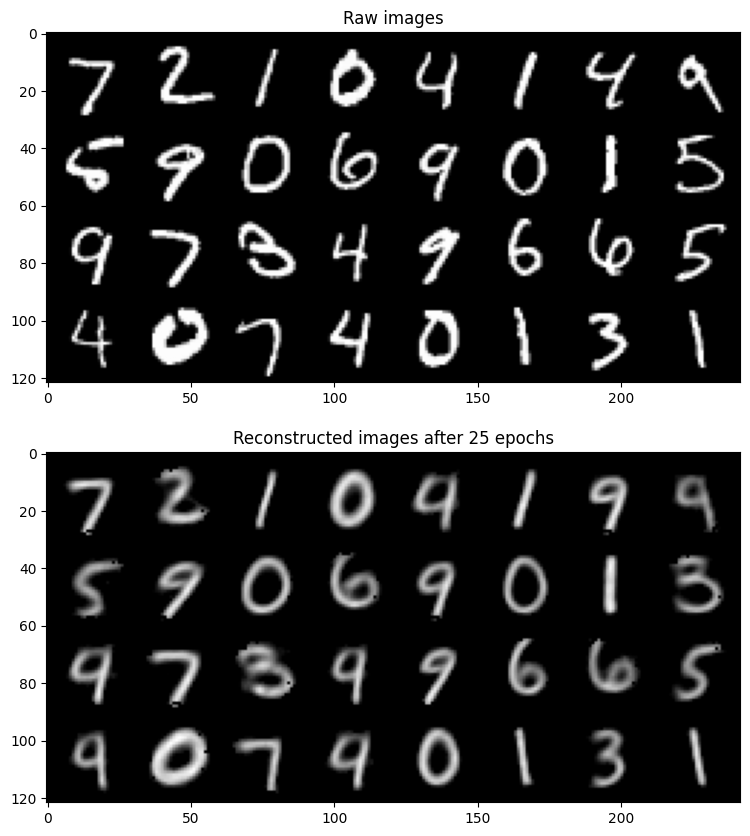

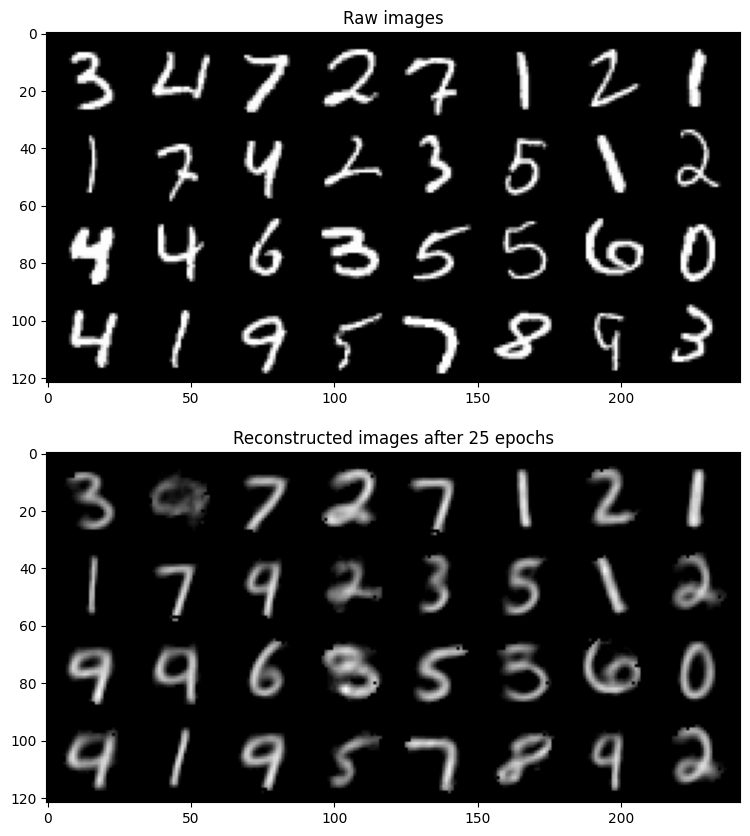

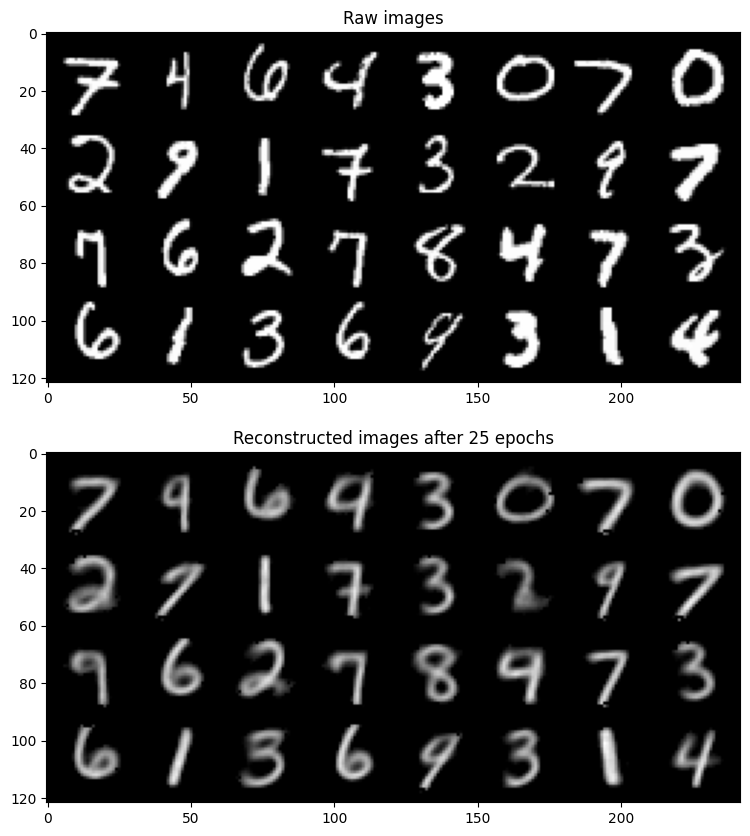

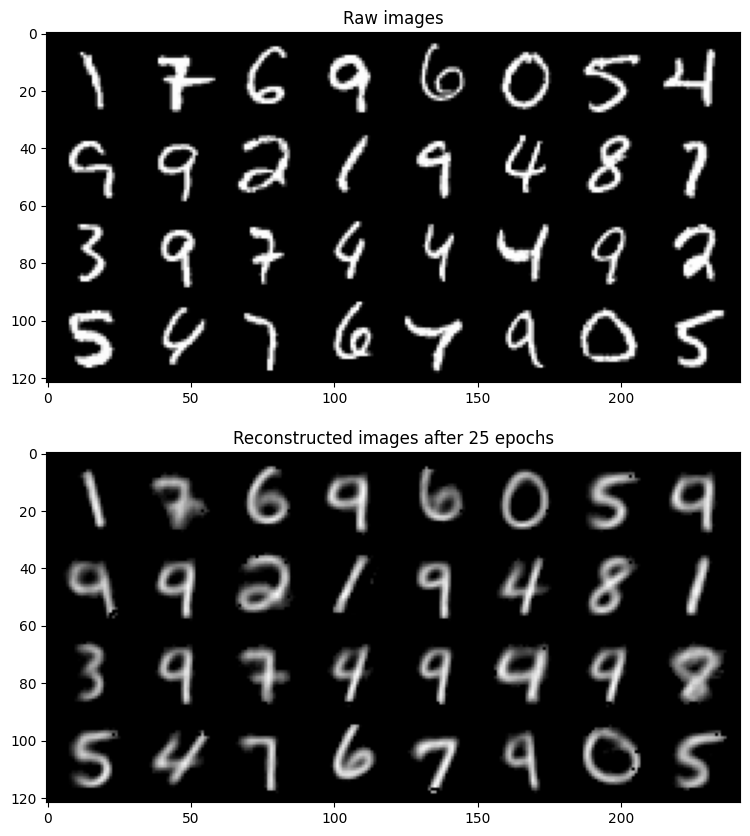

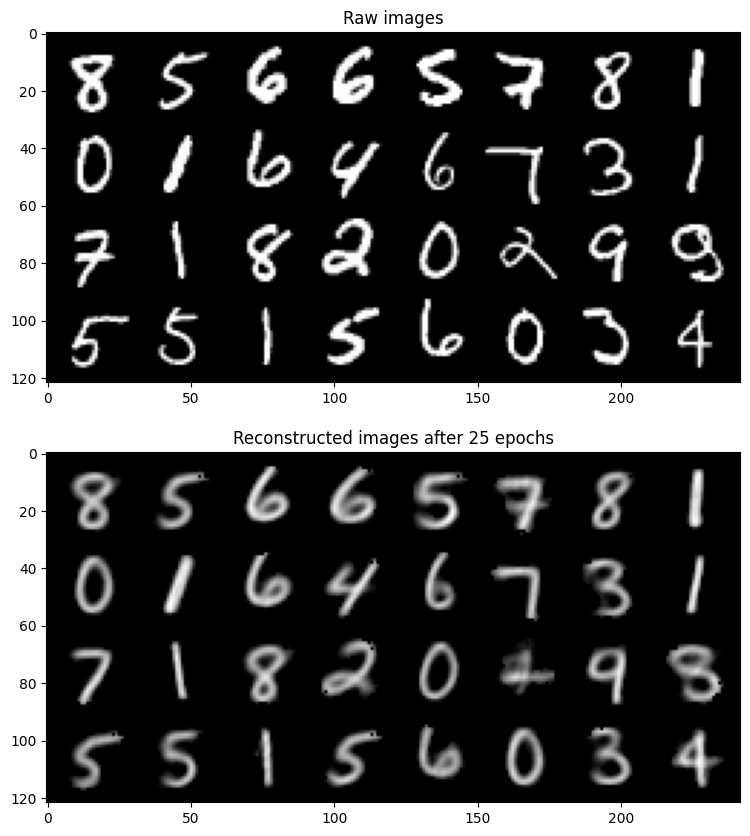

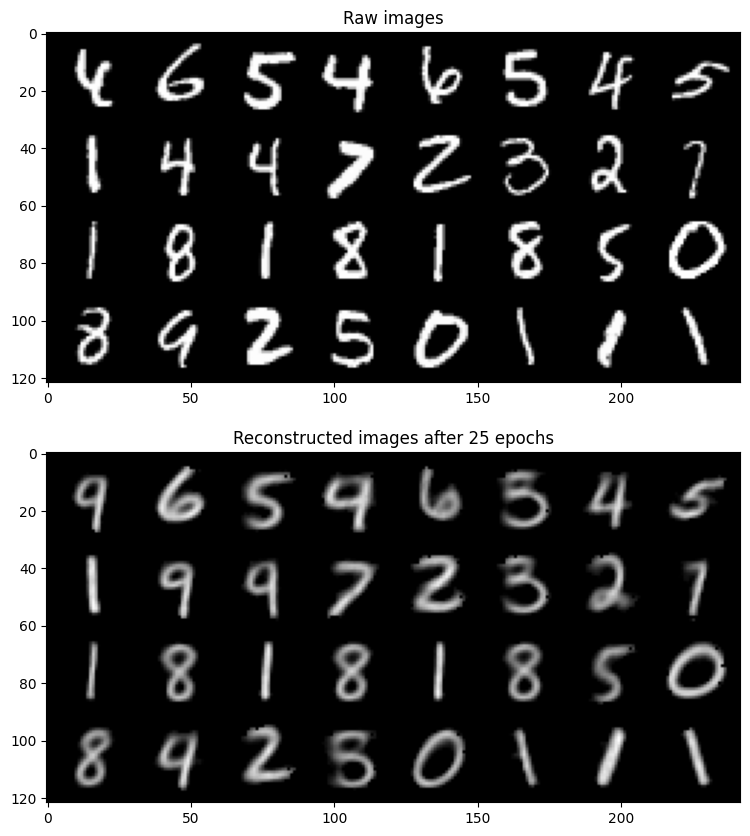

In [ ]:
test_loss = reconstruct(test_loader,model,criterion, n_images = 5)